In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial as factorial
import pandas as pd
from tqdm import tqdm
import seaborn as sn
import sys
from pathlib import Path
import matplotlib as mpl
import math

# import custom functions from src folder
module_path = str(Path.cwd() / "../../../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from util import *

In [10]:
def polar_to_cartesian(r, a):
    x = r*np.cos(a)
    y = r*np.sin(a)
    return x, y

def cartesian_to_polar(x, y):
    r = np.sqrt(x**2 + y**2)
    a = np.arctan(y/x)
    #Get angles in range 0, 2pi (tested)
    a = np.where(x < 0, a + np.pi, a)
    a = np.where(a < 0, a + 2*np.pi, a)
    return r, a

In [11]:
def plot_results(df, predkey, ax, suptitle):
    ax.set_title(suptitle)
    sn.set_theme(style="whitegrid")
    cmap = red_blue_cmap()

    sn.scatterplot(data = df, x="x1", y="x2", ax = ax, hue=predkey, 
                   hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                    palette=cmap, legend=False)
    
    ax.set_xlim(-25, 25)
    ax.set_ylim(-25, 25)
    return ax


In [ ]:
def polar_to_cartesian(r, a):
    x = r*np.cos(a)
    y = r*np.sin(a)
    return x, y

def cartesian_to_polar(x, y):
    r = np.sqrt(x**2 + y**2)
    a = np.arctan(y/x)
    #Get angles in range 0, 2pi (tested)
    a = np.where(x < 0, a + np.pi, a)
    a = np.where(a < 0, a + 2*np.pi, a)
    return r, a

def alpha(a2, r1, r2):
    return (r2*np.sin(a2)/(r1+r2*np.cos(a2)))

def beta(x1, x2, r1, r2):
    return((x1**2+x2**2-(r1**2+r2**2))/(2*r1*r2))

def theta2(x1, x2, r1, r2):
    x = np.sqrt(x1**2 + x2**2)
    u = 2*r1**2*(x**2+r2**2)-(x**2-r2**2)**2 -r1**4
    a2 = -2*np.arctan((np.sqrt(u))/((r1 - r2)**2 - x**2))
    
    # val = beta(x1, x2, r1, r2)
    # # We can get some rounding errors. If they are tiny, skip them.
    # if (abs(val) > 1) and (abs(val) - 1 < 0.001):
    #     if val < 0:
    #         val = -1# + 0.001
    #     else: val = 1# - 0.001
    # elif (abs(val) > 1) and (abs(val) - 1 > 0.001):
    #     print(f"Encountered strange beta value: {val} from input x1 {x1}, x2 {x2}.")
    if any(x < 0 for x in a2.flatten()) == True:
         print(f"Encountered strange theta1 value: {a2} from input x1 {x1}, x2 {x2}, u {u}.")
    elif any(x > np.pi for x in a2.flatten()) == True:
         print(f"Encountered strange theta1 value: {a2} from input x1 {x1}, x2 {x2}, u {u}.")
    #return(np.arccos(val))
    return a2

def theta1(x1, x2, r1, r2):
    #Piecewise defined
    x = np.sqrt(x1**2 + x2**2)
    u = 2*r1**2*(x**2+r2**2)-(x**2-r2**2)**2 -r1**4
    a1 = 2*np.arctan((2*r1*x2 - np.sqrt(u))/(x**2 + r1**2 + 2*r1*x1 - r2**2))
    a1 = np.where(a1 < 0, a1 + 2*np.pi, a1)

    # a1 = np.arctan(x2/x1)-np.arctan(alpha(theta2(x1, x2, r1, r2), r1, r2))
    # a1 = np.where(x1 < 0, a1 + np.pi, a1)
    # a1 = np.where(a1 < 0, a1 + 2*np.pi, a1)
    if any(x < 0 for x in a1.flatten()) == True:
         print(f"Encountered strange theta1 value: {a1} from input x1 {x1}, x2 {x2}, u {u}.")
    elif any(x > 2*np.pi for x in a1.flatten()) == True:
         print(f"Encountered strange theta1 value: {a1} from input x1 {x1}, x2 {x2}, u {u}.")
    
    return a1


def sqrtgamma_num(x1, x2, r1, r2, dx=0.001):
    #Sometimes get wrong sign
    def fix_difference(da):
        da = np.where(da > np.pi, da - 2*np.pi, da)
        da = np.where(da < -np.pi, da + 2*np.pi, da)
        return da
    da1x = fix_difference(theta1(x1+dx, x2, r1, r2) - theta1(x1, x2, r1, r2))
    da1y = fix_difference(theta1(x1, x2+dx, r1, r2) - theta1(x1, x2, r1, r2))
    da2x = fix_difference(theta2(x1+dx, x2, r1, r2) - theta2(x1, x2, r1, r2))
    da2y = fix_difference(theta2(x1, x2+dx, r1, r2) - theta2(x1, x2, r1, r2))
    val = da1x*da2y/(dx**2) - da1y*da2x/(dx**2)
    if any(x < 0 for x in val.flatten()) == True:
        print(f"Encountered strange sqrtgamma value: {val} from input x1 {x1}, x2 {x2}, r1 {r1}, r2 {r2}, .")
        print(da1x, da1y, da2x, da2y)
    return(abs(val))

def p_r1(r1, R1_min, c, kr, kb):
    # Gamma distribution
    if (c == "red"):
        kc = kr
    elif (c == "blue"):
        kc = kb
    else:
        print("Please input valid color.")
        return None
    z = r1 - R1_min
    return(kc*z**(kc - 1)*np.exp(-z)/(factorial(kc)))

def p_c(c):
    if (c == "red"):
        return 0.5
    if (c == "blue"):
        return 0.5

def p_theta1(a1, c, vary_a1=False):
    # Step wise distribution
    min_theta2 = 0
    max_theta2 = np.pi
    length = (max_theta2-min_theta2)
    if vary_a1:
        if c =="red":
            if a1 < np.pi/4:
                p_a1 = 0.4/(length)
            elif np.pi/4 < a1 < 3*np.pi/4:
                p_a1 = 1.6/(length)
            elif 3*np.pi/4 < a1 < 5*np.pi/4:
                p_a1 =0.4/(length)
            elif 5*np.pi/4 < a1 < 7*np.pi/4:
                p_a1 = 1.6/(length)
            else:
                p_a1 = 0.4/(length)
            return p_a1
        else:
            return 1/(max_theta2-min_theta2)
    else:
        return 1/(max_theta2-min_theta2)

def p_theta2():
    # Uniform distribution
    min_theta2 = 0
    max_theta2 = np.pi
    return 1/(max_theta2-min_theta2)

In [13]:
def P_c_and_x(c, x1, x2, R2, R1_min, kr, kb, vary_a1, n_x_mc:int = 10, n_r1_mc:int = 50):
    # Define area of x to integrate over
    # Easiest to define it in polar coordinates because of limits in r1 integral
    r, a = cartesian_to_polar(x1, x2)

    # Area is coordinate, plus/minus these values
    dr = 0.05
    da = 2*np.pi/100

    # MC sampling
    rng = np.random.default_rng()
    n_samples = n_x_mc
    # Make sure only legal rs
    if (r - dr < 0):
        # r should not be less than zero
        r_arr  = rng.uniform(0, r + dr, n_samples)
    else:
        if (r - dr > R1_min - R2):
            r_arr  = rng.uniform(r - dr/2, r + dr/2, n_samples)
        #Beyond undefined edge
        else:
            r_arr  = rng.uniform(R1_min - R2, R1_min - R2 + dr, n_samples)

    a_arr  = rng.uniform(a - da/2, a + da/2, n_samples)
    # If a_x is negative, wrap around to other side
    a_arr = np.where(a_arr < 0, a_arr + 2*np.pi, a_arr)

    # Convert back to cartesian coordinates
    x1_arr, x2_arr = polar_to_cartesian(r_arr, a_arr)

    # Integrate over area
    # Integral = Sum/Number of MC samples
    sum_integral_x = 0

    #print(f"Starting MC sampling in range {min(r_arr), max(r_arr)}, {min(a_arr), max(a_arr)}.")
    for n in range(n_samples):
        # Different r1 limits if at the edge of the gamma distribution
        r_n = r_arr[n]
        x1_n, x2_n = x1_arr[n], x2_arr[n]
        #print(r_n, a_n)
        # Is there a border?
        if (R1_min - R2 > 0):
            if ((R1_min - R2 <= r_n) & (r_n <= R1_min + R2)):
                r1_min = R1_min
                r1_max = r_n + R2
            else:
                r1_min = abs(r_n - R2)
                r1_max = r_n + R2
        else:
            r1_min = abs(r_n - R2)
            r1_max = r_n + R2

        # Integrate over all possible r1
        # Very simple approximation to r1 integral for now
        n_r1 = n_r1_mc
        r1_arr  = rng.uniform(r1_min, r1_max, n_r1)
        val = np.zeros(n_r1)
        for i, r1 in enumerate(r1_arr):
            theta1_n = theta1(x1_n, x2_n, r1, R2)
            theta2_n = theta2(x1_n, x2_n, r1, R2)
            # Skip if values are too close to undefined edge
            # Edit n_r1 to match skipping
            if theta1_n < 0.01:
                val[i] = 0
                n_r1 = n_r1 -1
            elif (2*np.pi - theta1_n ) < 0.01:
                val[i] = 0
                n_r1 = n_r1 -1
            elif theta2_n < 0.01:
                val[i] = 0
                n_r1 = n_r1 -1
            elif (np.pi - theta2_n ) < 0.01:
                val[i] = 0
                n_r1 = n_r1 -1
            else:
                val[i] = p_theta1(theta1_n, c, vary_a1)*p_theta2()*p_r1(r1, R1_min, c, kr, kb)*sqrtgamma_num(x1_n, x2_n, r1, R2)
        
        # Potential error source
        if(n_r1 > 0):
                dr1 = (r1_max - r1_min)/n_r1
                integral_r1 = math.fsum(val)*dr1
        else: 
            integral_r1 = 0
        
        sum_integral_x = sum_integral_x + integral_r1
    # Is this how it works?
    integral_x = (4*r*dr*da/n_samples)*p_c(c)*sum_integral_x

    return integral_x

In [18]:
# Read data file
#filepath = "../data/x1_x2_grid.csv"
#data = pd.read_csv(filepath, index_col=0)
x1_list = np.linspace(-20, 10, 30)
x2_list = np.linspace(-20, 10, 30)
data = pd.DataFrame(columns = ["x1", "x2"])
data["x1"] = x1_list
data["x2"] = x2_list
n_data = len(data)

R2 = 7
R1_min = 0
n_x_mc = 10
n_r1_mc = 20
k_red = 15
k_blue = 5
vary_a1 = False

scale = 1
vary_a1 = False
vary_R2 = False #Not adapted for this yet
p_red = 0.5
tag = f'r2_{R2}_kr{k_red}_kb{k_blue}_r1min{R1_min}_s{scale}_vary_r2_{vary_R2}_vary_a1_{vary_a1}_pRed_{p_red}'

data["r_x"], data["a_x"] = cartesian_to_polar(data["x1"], data["x2"])
P_red_and_x = np.zeros(n_data)
P_blue_and_x = np.zeros(n_data)

print(f"Starting calculations for {n_data} datapoints.")


for i in range(n_data):
    #Undefined inside boundary
    if data["r_x"][i] < (R1_min-R2): #If R1_min = 0, this is never true
        P_red_and_x[i] = 0.5
        P_blue_and_x[i] = 0.5
    else:
        P_red_and_x[i] = P_c_and_x("red", data["x1"][i], data["x2"][i], R2, R1_min, k_red, k_blue, vary_a1, n_x_mc = n_x_mc, n_r1_mc = n_r1_mc)
        P_blue_and_x[i] = P_c_and_x("blue", data["x1"][i], data["x2"][i], R2, R1_min, k_red, k_blue, vary_a1, n_x_mc = n_x_mc, n_r1_mc = n_r1_mc)

data["P_red_and_x"] = P_red_and_x
data["P_blue_and_x"] = P_blue_and_x
data["P_x"] = data["P_red_and_x"] + data["P_blue_and_x"]
data["P_red_given_x"] = data["P_red_and_x"]/data["P_x"]
data["P_blue_given_x"] = data["P_blue_and_x"]/data["P_x"]


Starting calculations for 30 datapoints.


<Axes: title={'center': '20'}, xlabel='x$_1$', ylabel='x$_2$'>

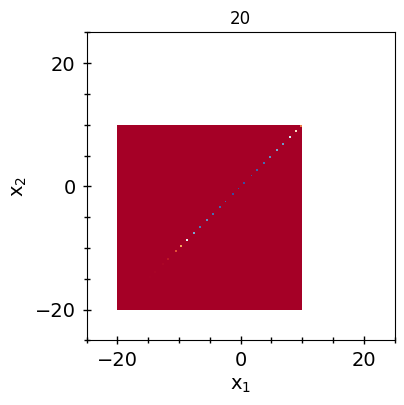

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
plot_grid(data, "P_blue_given_x", ax, 20)